I this EDA, i will try to examine the data using summary statistics in order to contextualize some of the other findings

In [24]:
# imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go
import json
from typing import List, Any, Dict, Tuple

from helper_functions import clean_data_age_gender, split_csv, calculate_household_stats

#Future proofing of the way we use pandas
pd.options.mode.copy_on_write = True

data_path = Path().cwd().parent / 'data' / 'census' / 'combined_data_raw.csv'

Try to figure ou how to locate families with 1-2 children by:
- grouping by families
- only looking at families with 2 parents (adults over the age of 18)
- and of these, only ones with 1-2 children aged between 0-18

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_27657/3812272913.py:97: DtypeWarning: Columns (2,3,4,7,9,10,11,12,13,14,15,18,19,20,21,22,23,24,26,27,28,29,30,31,44,47,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(data_path)


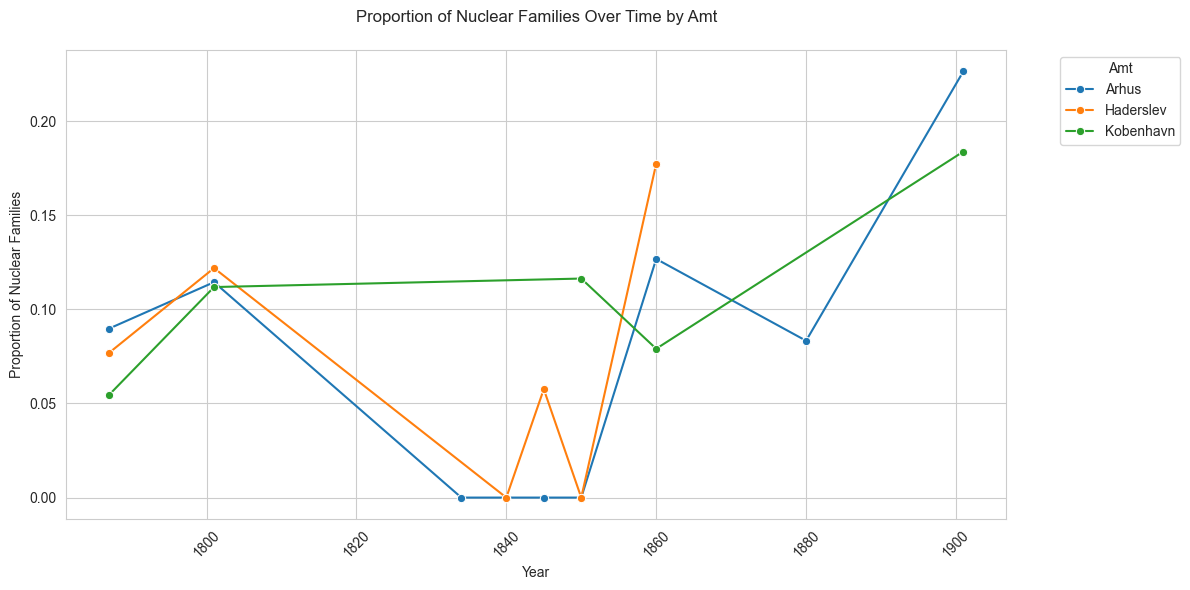

In [25]:
def identify_nuclear_families(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies nuclear families in the dataset based on household composition.
    
    Args:
        df (pd.DataFrame): Input DataFrame with census data
        
    Returns:
        pd.DataFrame: DataFrame with nuclear family identification
    """
    # Group by household_id to analyze family composition
    household_compositions = df.groupby('household_id').agg({
        'age_full_years': list,
        'Stilling_i_husstanden': list,
        'amt': 'first',
        'year': 'first'
    }).reset_index()
    
    def is_nuclear_family(row: pd.Series) -> bool:
        positions = row['Stilling_i_husstanden']
        ages = row['age_full_years']
        
        # Count parents (assuming traditional terms used in historical census)
        parents = sum(1 for pos in positions if 'husfader' in str(pos).lower() 
                     or 'husmoder' in str(pos).lower() 
                     or 'mand' in str(pos).lower() 
                     or 'kone' in str(pos).lower()
                     or 'husfader' in str(pos).lower())
        
        # Count children (look for 'barn' or 'søn' or 'datter' in position)
        children = sum(1 for pos, age in zip(positions, ages) 
                      if ('barn' in str(pos).lower() 
                          or 'søn' in str(pos).lower() 
                          or 'datter' in str(pos).lower()) 
                      and float(age) < 18)
        
        # Nuclear family: 2 parents and 1-2 children
        return parents == 2 and 1 <= children <= 2

    # Apply nuclear family identification
    household_compositions['is_nuclear'] = household_compositions.apply(is_nuclear_family, axis=1)
    
    return household_compositions

def calculate_nuclear_family_proportions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the proportion of nuclear families by year and amt.
    
    Args:
        df (pd.DataFrame): DataFrame with nuclear family identification
        
    Returns:
        pd.DataFrame: DataFrame with proportions by year and amt
    """
    # Group by year and amt to calculate proportions
    proportions = df.groupby(['year', 'amt']).agg({
        'is_nuclear': ['count', 'sum']
    }).reset_index()
    
    # Calculate proportions
    proportions.columns = ['year', 'amt', 'total_households', 'nuclear_families']
    proportions['proportion'] = proportions['nuclear_families'] / proportions['total_households']
    
    return proportions

# Create visualization
def plot_nuclear_family_trends(proportions: pd.DataFrame) -> None:
    """
    Creates a line plot showing the proportion of nuclear families over time by amt.
    
    Args:
        proportions (pd.DataFrame): DataFrame with nuclear family proportions
    """
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Create line plot
    sns.lineplot(data=proportions, 
                x='year', 
                y='proportion', 
                hue='amt',
                marker='o')
    
    plt.title('Proportion of Nuclear Families Over Time by Amt', pad=20)
    plt.xlabel('Year')
    plt.ylabel('Proportion of Nuclear Families')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add legend with better positioning
    plt.legend(title='Amt', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()

# Load the data
combined_df = pd.read_csv(data_path)

# Identify nuclear families
nuclear_families = identify_nuclear_families(combined_df)

# Calculate proportions of nuclear families
nuclear_proportions = calculate_nuclear_family_proportions(nuclear_families)

# Plot the trends
plot_nuclear_family_trends(nuclear_proportions)

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_27657/3816885806.py:121: DtypeWarning: Columns (2,3,4,7,9,10,11,12,13,14,15,18,19,20,21,22,23,24,26,27,28,29,30,31,44,47,49,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(data_path)


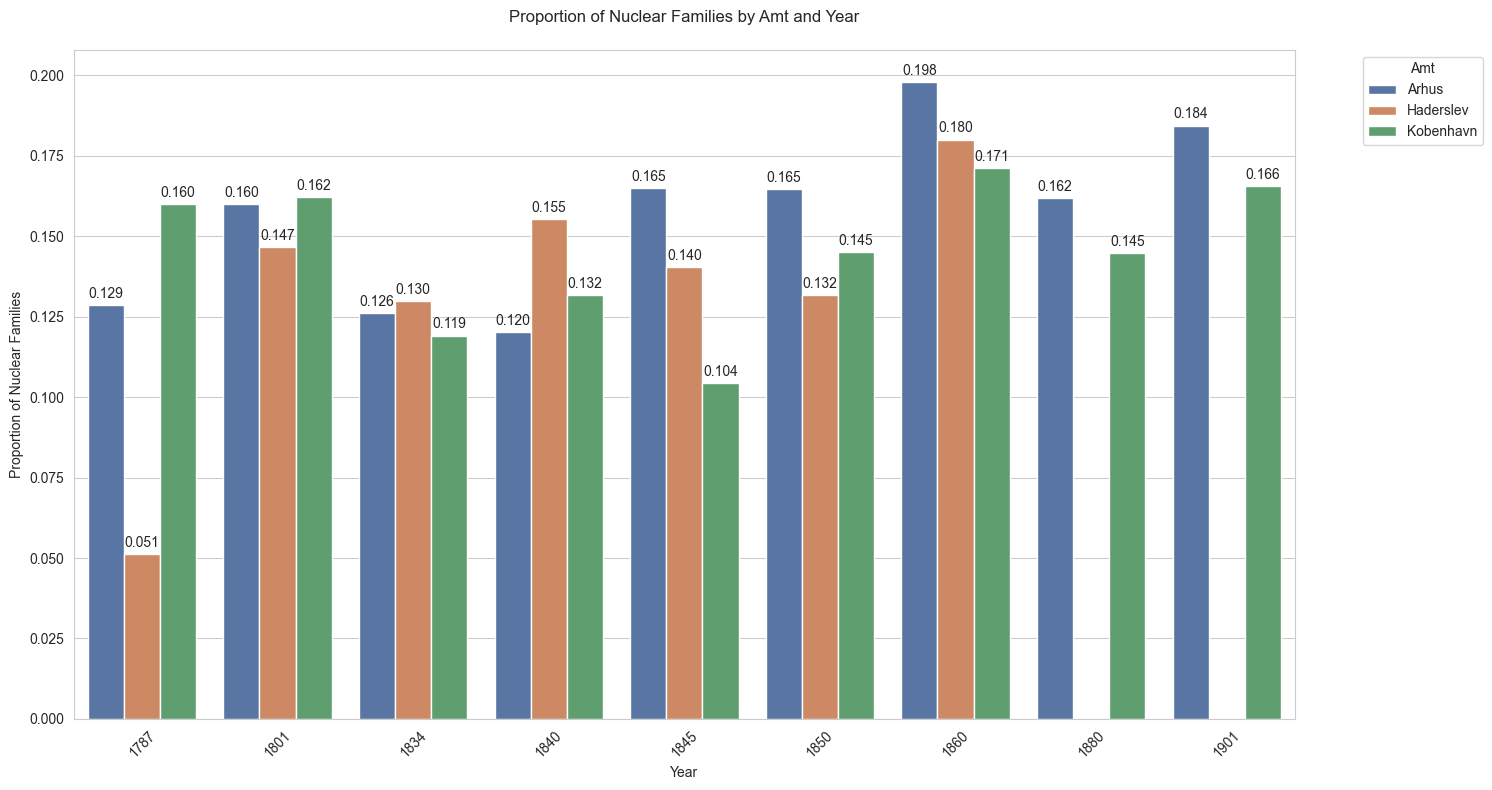

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List
import numpy as np

def identify_nuclear_families(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies potential nuclear families based on household age and sex composition.
    A nuclear family is defined as having:
    - One adult male (18+)
    - One adult female (18+)
    - 1-2 children under 18
    
    Args:
        df (pd.DataFrame): Input DataFrame with census data
        
    Returns:
        pd.DataFrame: DataFrame with nuclear family identification
    """
    # Create unique household identifier
    df['unique_household_id'] = df['household_id'].astype(str) + '_' + df['amt'] + '_' + df['year'].astype(str)
    
    # First convert age to numeric, handling any errors
    df['age_full_years'] = pd.to_numeric(df['age_full_years'], errors='coerce')
    
    # Create household composition summary
    household_summary = df.groupby('unique_household_id').agg({
        'amt': 'first',
        'year': 'first'
    }).reset_index()
    
    # Count adults by sex in each household
    adult_males = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'm')
    ].groupby('unique_household_id').size()
    
    adult_females = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'k')
    ].groupby('unique_household_id').size()
    
    # Count children in each household
    children = df[
        df['age_full_years'] < 18
    ].groupby('unique_household_id').size()
    
    # Add these counts to the household summary
    household_summary['adult_males'] = household_summary['unique_household_id'].map(adult_males).fillna(0)
    household_summary['adult_females'] = household_summary['unique_household_id'].map(adult_females).fillna(0)
    household_summary['children'] = household_summary['unique_household_id'].map(children).fillna(0)
    
    # Identify nuclear families
    household_summary['is_nuclear'] = (
        (household_summary['adult_males'] == 1) & 
        (household_summary['adult_females'] == 1) & 
        (household_summary['children'].between(1, 2))
    )
    
    return household_summary

def calculate_nuclear_family_proportions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the proportion of nuclear families by year and amt.
    
    Args:
        df (pd.DataFrame): DataFrame with nuclear family identification
        
    Returns:
        pd.DataFrame: DataFrame with proportions by year and amt
    """
    # Group by year and amt to calculate proportions
    proportions = df.groupby(['year', 'amt']).agg({
        'is_nuclear': ['count', 'sum']
    }).reset_index()
    
    # Calculate proportions
    proportions.columns = ['year', 'amt', 'total_households', 'nuclear_families']
    proportions['proportion'] = proportions['nuclear_families'] / proportions['total_households']
    
    return proportions

def plot_nuclear_family_trends(proportions: pd.DataFrame) -> None:
    """
    Creates a grouped bar plot showing the proportion of nuclear families by amt for each year.
    
    Args:
        proportions (pd.DataFrame): DataFrame with nuclear family proportions
    """
    plt.figure(figsize=(15, 8))
    sns.set_style("whitegrid")
    
    # Create grouped bar plot
    ax = sns.barplot(
        data=proportions,
        x='year',
        y='proportion',
        hue='amt',
        palette='deep'
    )
    
    plt.title('Proportion of Nuclear Families by Amt and Year', pad=20)
    plt.xlabel('Year')
    plt.ylabel('Proportion of Nuclear Families')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add legend with better positioning
    plt.legend(title='Amt', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()

# Load the data
combined_df = pd.read_csv(data_path)

# Identify nuclear families
nuclear_families = identify_nuclear_families(combined_df)

# Calculate proportions of nuclear families
nuclear_proportions = calculate_nuclear_family_proportions(nuclear_families)

# Plot the trends
plot_nuclear_family_trends(nuclear_proportions)

In [27]:
def classify_household_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Classifies households into three categories:
    - Nuclear families (2 adults of opposite sex, 1-2 children)
    - Larger than nuclear (more members than nuclear family)
    - Smaller than nuclear (fewer members than nuclear family)
    
    Args:
        df (pd.DataFrame): Input DataFrame with census data
        
    Returns:
        pd.DataFrame: DataFrame with household classifications
    """
    # Create unique household identifier
    df['unique_household_id'] = df['household_id'].astype(str) + '_' + df['amt'] + '_' + df['year'].astype(str)
    
    # Convert age to numeric
    df['age_full_years'] = pd.to_numeric(df['age_full_years'], errors='coerce')
    
    # Create household composition summary
    household_summary = df.groupby('unique_household_id').agg({
        'amt': 'first',
        'year': 'first'
    }).reset_index()
    
    # Count household members by type
    adult_males = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'm')
    ].groupby('unique_household_id').size()
    
    adult_females = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'k')
    ].groupby('unique_household_id').size()
    
    children = df[
        df['age_full_years'] < 18
    ].groupby('unique_household_id').size()
    
    total_members = df.groupby('unique_household_id').size()
    
    # Add counts to summary
    household_summary['adult_males'] = household_summary['unique_household_id'].map(adult_males).fillna(0)
    household_summary['adult_females'] = household_summary['unique_household_id'].map(adult_females).fillna(0)
    household_summary['children'] = household_summary['unique_household_id'].map(children).fillna(0)
    household_summary['total_members'] = household_summary['unique_household_id'].map(total_members)
    
    # Classify households
    household_summary['household_type'] = 'other'
    
    # Nuclear family condition
    nuclear_condition = (
        (household_summary['adult_males'] == 1) & 
        (household_summary['adult_females'] == 1) & 
        (household_summary['children'].between(1, 2))
    )
    household_summary.loc[nuclear_condition, 'household_type'] = 'Nuclear'
    
    # Larger than nuclear condition (more than 4 members or more adults/children than nuclear)
    larger_condition = (
        (household_summary['total_members'] > 4) |
        (household_summary['adult_males'] + household_summary['adult_females'] > 2) |
        (household_summary['children'] > 2)
    )
    household_summary.loc[larger_condition & ~nuclear_condition, 'household_type'] = 'Larger than nuclear'
    
    # Smaller than nuclear condition (everything else)
    household_summary.loc[
        (~nuclear_condition & ~larger_condition),
        'household_type'
    ] = 'Smaller than nuclear'
    
    return household_summary

def calculate_household_type_proportions(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the proportion of each household type by year and amt.
    
    Args:
        df (pd.DataFrame): DataFrame with household classifications
        
    Returns:
        pd.DataFrame: DataFrame with proportions by year, amt, and household type
    """
    # Calculate proportions
    proportions = df.groupby(['year', 'amt', 'household_type']).size().reset_index()
    proportions.columns = ['year', 'amt', 'household_type', 'count']
    
    # Calculate total households for each year and amt
    totals = df.groupby(['year', 'amt']).size().reset_index()
    totals.columns = ['year', 'amt', 'total']
    
    # Merge and calculate proportions
    proportions = proportions.merge(totals, on=['year', 'amt'])
    proportions['proportion'] = proportions['count'] / proportions['total']
    
    return proportions

def create_summary_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates summary statistics for household distributions.
    
    Args:
        df (pd.DataFrame): DataFrame with household data
        
    Returns:
        pd.DataFrame: Summary statistics
    """
    summary_stats = df.groupby('amt').agg({
        'total_members': ['count', 'mean', 'std', 'min', 'max'],
        'adult_males': 'mean',
        'adult_females': 'mean',
        'children': 'mean'
    }).round(2)
    
    # Flatten column names
    summary_stats.columns = [
        'Number of households',
        'Mean household size',
        'Std household size',
        'Min household size',
        'Max household size',
        'Mean adult males',
        'Mean adult females',
        'Mean children'
    ]
    
    return summary_stats

def plot_household_types(proportions: pd.DataFrame) -> None:
    """
    Creates separate plots for each amt showing proportions of different household types.
    
    Args:
        proportions (pd.DataFrame): DataFrame with household type proportions
    """
    # Create a subplot for each amt
    amts = sorted(proportions['amt'].unique())
    fig, axes = plt.subplots(len(amts), 1, figsize=(15, 5*len(amts)))
    
    # Color palette for household types
    colors = {'Nuclear': '#2ecc71', 
              'Larger than nuclear': '#e74c3c', 
              'Smaller than nuclear': '#3498db'}
    
    for idx, amt in enumerate(amts):
        amt_data = proportions[proportions['amt'] == amt]
        
        # Create grouped bar plot
        sns.barplot(
            data=amt_data,
            x='year',
            y='proportion',
            hue='household_type',
            palette=colors,
            ax=axes[idx]
        )
        
        # Customize plot
        axes[idx].set_title(f'Household Type Distribution in {amt}')
        axes[idx].set_xlabel('Year')
        axes[idx].set_ylabel('Proportion')
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add value labels
        for container in axes[idx].containers:
            axes[idx].bar_label(container, fmt='%.3f', padding=3)
    
    plt.tight_layout()

# Example usage code
def analyze_households(df: pd.DataFrame) -> Tuple[pd.DataFrame, None]:
    """
    Performs complete household analysis and creates visualizations.
    
    Args:
        df (pd.DataFrame): Input census data
        
    Returns:
        Tuple[pd.DataFrame, None]: Summary statistics and None (plots are displayed)
    """
    # Classify households and calculate proportions
    household_data = classify_household_types(df)
    proportions_data = calculate_household_type_proportions(household_data)
    
    # Create and display summary statistics
    summary_stats = create_summary_statistics(household_data)
    print("\nHousehold Distribution Summary Statistics:")
    print(summary_stats)
    
    # Create plots
    plot_household_types(proportions_data)
    
    return summary_stats


Summary Statistics for Arhus


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,5333,4.46,2.89,1.00,42.00,2.76,1.36,1.40,1.69,0.61,1.14,1.00,1.65
1801,5731,4.39,2.77,1.00,40.00,2.70,1.36,1.34,1.70,0.63,1.11,1.01,1.64
1834,7012,5.20,4.02,1.00,137.00,3.04,1.51,1.53,2.17,0.71,1.55,1.34,2.12
1840,5673,6.76,8.63,1.00,351.00,4.02,1.99,2.03,2.74,0.68,2.74,2.55,4.04
1845,7885,5.09,3.54,1.00,112.00,3.09,1.54,1.55,1.99,0.64,1.70,1.19,1.85
1850,7792,5.28,4.15,1.00,190.00,3.21,1.58,1.63,2.07,0.64,1.56,1.41,2.13
1860,10022,4.83,3.44,1.00,137.00,2.92,1.47,1.45,1.91,0.65,1.61,1.25,1.80
1880,10907,6.22,7.13,1.00,409.00,3.77,1.87,1.90,2.44,0.65,3.52,2.78,2.73
1901,22009,4.50,5.13,1.00,475.00,2.64,1.29,1.35,1.82,0.69,2.60,2.05,2.22



Summary Statistics for Haderslev


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,39,6.03,2.86,2.00,13.00,4.10,2.23,1.87,1.92,0.47,1.13,0.83,1.84
1801,2058,4.88,2.41,1.00,17.00,3.02,1.38,1.64,1.85,0.61,0.91,0.86,1.75
1834,100,5.51,3.01,1.00,14.00,3.19,1.66,1.53,2.32,0.73,1.11,0.77,1.83
1840,663,5.84,6.19,1.00,101.00,3.49,1.65,1.84,2.35,0.67,2.15,2.26,2.50
1845,5676,5.15,4.29,1.00,178.00,3.13,1.46,1.67,2.01,0.64,1.72,2.44,2.06
1850,129,5.53,2.73,1.00,16.00,3.20,1.50,1.70,2.33,0.73,1.10,0.94,1.86
1860,10196,4.87,3.08,1.00,59.00,2.99,1.47,1.52,1.87,0.63,1.41,1.22,1.78



Summary Statistics for Kobenhavn


,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
year,,,,,,,,,,,,,
1787,22938,4.90,6.30,1.00,342.00,3.37,1.73,1.64,1.51,0.45,2.96,2.38,2.56
1801,25905,4.83,5.73,1.00,300.00,3.30,1.67,1.63,1.52,0.46,2.88,2.96,2.06
1834,10896,5.59,12.47,1.00,1161.00,3.57,1.70,1.87,2.03,0.57,4.45,7.29,2.38
1840,30380,5.14,7.08,1.00,516.00,3.44,1.62,1.82,1.69,0.49,4.69,3.29,2.05
1845,27864,5.83,11.31,1.00,1419.00,3.95,1.89,2.06,1.87,0.47,5.93,5.87,2.36
1850,35274,4.76,5.78,1.00,430.00,3.18,1.46,1.72,1.57,0.49,3.49,2.85,2.19
1860,44143,4.58,5.64,1.00,745.00,3.04,1.45,1.59,1.54,0.51,4.15,2.14,1.87
1880,67788,4.64,5.84,1.00,497.00,3.06,1.40,1.66,1.54,0.50,3.18,2.59,2.43
1901,55558,4.04,3.81,1.00,380.00,2.59,1.18,1.41,1.42,0.55,2.39,1.37,1.99


,amt,year,Number of households,Mean household size,Std household size,Min household size,Max household size,Adults per household,Mean adult males,Mean adult females,Mean children,Children to adults ratio,Std adult males,Std adult females,Std children
0,Arhus,1787,5333,4.46,2.89,1,42,2.76,1.36,1.40,1.69,0.61,1.14,1.00,1.65
1,Arhus,1801,5731,4.39,2.77,1,40,2.70,1.36,1.34,1.70,0.63,1.11,1.01,1.64
2,Arhus,1834,7012,5.20,4.02,1,137,3.04,1.51,1.53,2.17,0.71,1.55,1.34,2.12
3,Arhus,1840,5673,6.76,8.63,1,351,4.02,1.99,2.03,2.74,0.68,2.74,2.55,4.04
4,Arhus,1845,7885,5.09,3.54,1,112,3.09,1.54,1.55,1.99,0.64,1.70,1.19,1.85
5,Arhus,1850,7792,5.28,4.15,1,190,3.21,1.58,1.63,2.07,0.64,1.56,1.41,2.13
6,Arhus,1860,10022,4.83,3.44,1,137,2.92,1.47,1.45,1.91,0.65,1.61,1.25,1.80
7,Arhus,1880,10907,6.22,7.13,1,409,3.77,1.87,1.90,2.44,0.65,3.52,2.78,2.73
8,Arhus,1901,22009,4.50,5.13,1,475,2.64,1.29,1.35,1.82,0.69,2.60,2.05,2.22
9,Haderslev,1787,39,6.03,2.86,2,13,4.10,2.23,1.87,1.92,0.47,1.13,0.83,1.84


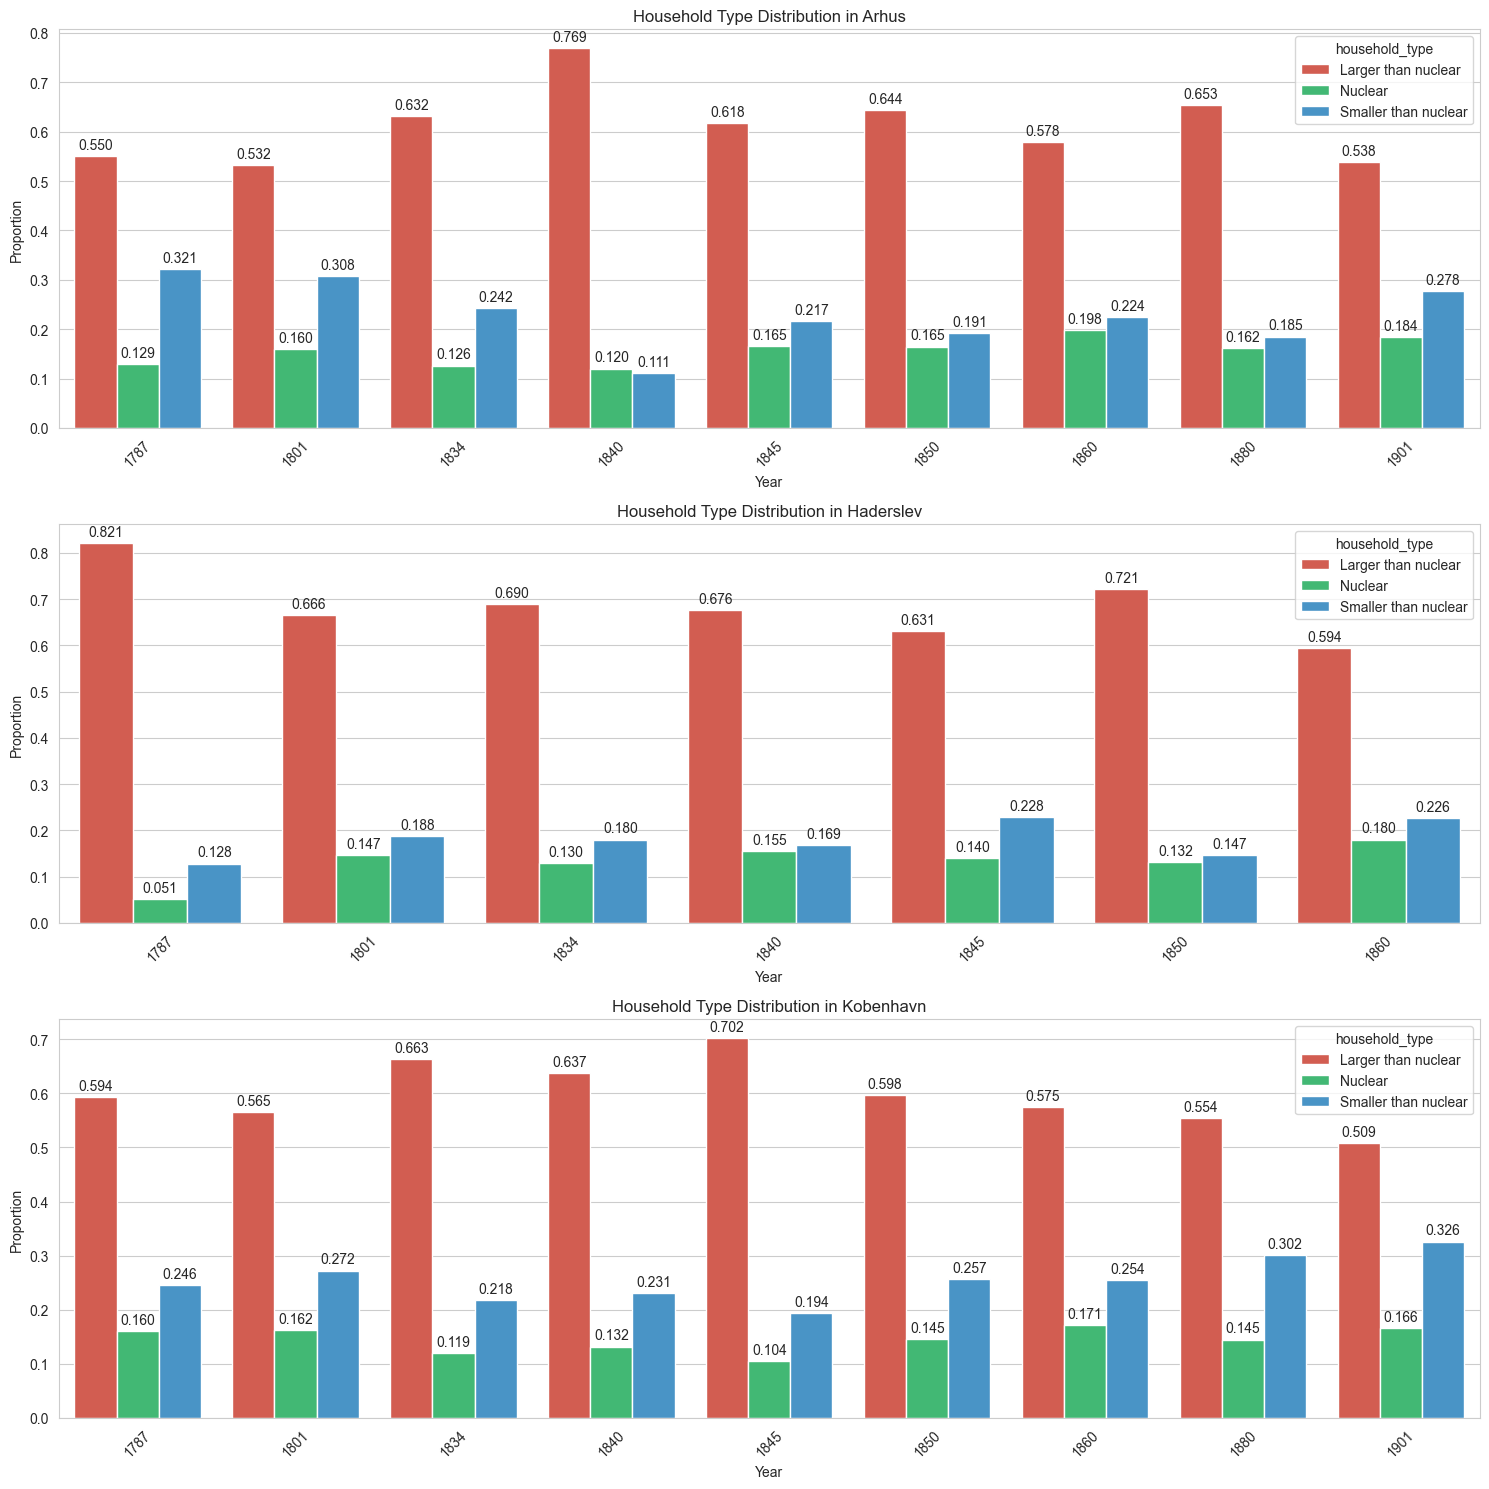

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import numpy as np

def create_temporal_summary_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates detailed summary statistics for household distributions by amt and year.
    
    Args:
        df (pd.DataFrame): DataFrame with household data
        
    Returns:
        pd.DataFrame: Summary statistics with temporal dimension
    """
    # Create multi-level summary statistics
    summary_stats = df.groupby(['amt', 'year']).agg({
        'total_members': ['count', 'mean', 'std', 'min', 'max'],
        'adult_males': ['mean', 'std'],
        'adult_females': ['mean', 'std'],
        'children': ['mean', 'std']
    }).round(2)
    
    # Flatten and rename columns for better readability
    summary_stats.columns = [
        'Number of households',
        'Mean household size',
        'Std household size',
        'Min household size',
        'Max household size',
        'Mean adult males',
        'Std adult males',
        'Mean adult females',
        'Std adult females',
        'Mean children',
        'Std children'
    ]
    
    # Reset index to make amt and year visible columns
    summary_stats = summary_stats.reset_index()
    
    # Sort by amt and year for better readability
    summary_stats = summary_stats.sort_values(['amt', 'year'])
    
    # Add some derived statistics
    summary_stats['Adults per household'] = (
        summary_stats['Mean adult males'] + summary_stats['Mean adult females']
    ).round(2)
    
    summary_stats['Children to adults ratio'] = (
        summary_stats['Mean children'] / 
        (summary_stats['Mean adult males'] + summary_stats['Mean adult females'])
    ).round(2)
    
    # Reorder columns for better presentation
    column_order = [
        'amt', 'year',
        'Number of households',
        'Mean household size',
        'Std household size',
        'Min household size',
        'Max household size',
        'Adults per household',
        'Mean adult males',
        'Mean adult females',
        'Mean children',
        'Children to adults ratio',
        'Std adult males',
        'Std adult females',
        'Std children'
    ]
    
    summary_stats = summary_stats[column_order]
    
    return summary_stats

def display_formatted_statistics(stats_df: pd.DataFrame) -> None:
    """
    Displays the summary statistics in a nicely formatted way for each amt.
    
    Args:
        stats_df (pd.DataFrame): DataFrame with summary statistics
    """
    # For each amt, display its statistics
    for amt in stats_df['amt'].unique():
        print(f"\n{'='*80}")
        print(f"Summary Statistics for {amt}")
        print('='*80)
        
        amt_stats = stats_df[stats_df['amt'] == amt].copy()
        
        # Drop the amt column for cleaner display
        amt_stats = amt_stats.drop('amt', axis=1)
        
        # Set year as index for cleaner display
        amt_stats = amt_stats.set_index('year')
        
        # Display with pandas styling
        display(amt_stats.style
               .format({col: '{:.2f}' for col in amt_stats.columns if 'Number' not in col})
               .background_gradient(subset=['Mean household size', 'Adults per household', 
                                         'Mean children', 'Children to adults ratio'])
               .set_caption(f"Temporal Summary Statistics for {amt}"))

def analyze_households_temporal(df: pd.DataFrame) -> Tuple[pd.DataFrame, None]:
    """
    Performs complete household analysis with temporal dimension and creates visualizations.
    
    Args:
        df (pd.DataFrame): Input census data
        
    Returns:
        Tuple[pd.DataFrame, None]: Summary statistics and None (plots are displayed)
    """
    # Classify households and calculate proportions
    household_data = classify_household_types(df)  # Using the function from previous code
    proportions_data = calculate_household_type_proportions(household_data)  # Using the function from previous code
    
    # Create and display temporal summary statistics
    summary_stats = create_temporal_summary_statistics(household_data)
    display_formatted_statistics(summary_stats)
    
    # Create plots (using the plotting functions from previous code)
    plot_household_types(proportions_data)
    
    return summary_stats

analyze_households_temporal(combined_df)

Notable takeaways:
- Nuclear households growths moslty in the rural areas of Haderslev (though it is remarkably stable)
- The proportion of larger than nuclear households falls in all amts, but the most remarkable fall seems to be in cph.
- Households smaller than nuclear seems to become incresingly common, especially in cph. This should not be the case with the traditional narrative of the inustrialization

In [31]:
import pandas as pd
from typing import Set, Dict, List
import numpy as np

def get_nuclear_family_parent_jobs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies parents in nuclear families and extracts their jobs.
    
    Args:
        df (pd.DataFrame): Input DataFrame with census data
        
    Returns:
        pd.DataFrame: DataFrame with nuclear family parents and their jobs
    """
    # Create unique household identifier
    df['unique_household_id'] = df['household_id'].astype(str) + '_' + df['amt'] + '_' + df['year'].astype(str)
    
    # First identify nuclear families
    # Convert age to numeric
    df['age_full_years'] = pd.to_numeric(df['age_full_years'], errors='coerce')
    
    # Group households to identify nuclear families
    household_comp = df.groupby('unique_household_id').agg({
        'amt': 'first',
        'year': 'first'
    }).reset_index()
    
    # Count members by type in each household
    adult_males = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'm')
    ].groupby('unique_household_id').size()
    
    adult_females = df[
        (df['age_full_years'] >= 18) & 
        (df['sex'] == 'k')
    ].groupby('unique_household_id').size()
    
    children = df[
        df['age_full_years'] < 18
    ].groupby('unique_household_id').size()
    
    # Add counts to summary
    household_comp['adult_males'] = household_comp['unique_household_id'].map(adult_males).fillna(0)
    household_comp['adult_females'] = household_comp['unique_household_id'].map(adult_females).fillna(0)
    household_comp['children'] = household_comp['unique_household_id'].map(children).fillna(0)
    
    # Identify nuclear families
    nuclear_households = household_comp[
        (household_comp['adult_males'] == 1) & 
        (household_comp['adult_females'] == 1) & 
        (household_comp['children'].between(1, 2))
    ]['unique_household_id']
    
    # Get all individuals from nuclear families
    nuclear_family_members = df[df['unique_household_id'].isin(nuclear_households)].copy()
    
    # Identify parents (adults) in nuclear families
    nuclear_parents = nuclear_family_members[
        (nuclear_family_members['age_full_years'] >= 18)
    ].copy()
    
    # Clean and standardize job titles
    nuclear_parents['Erhverv'] = nuclear_parents['Erhverv'].str.strip().str.lower()
    
    return nuclear_parents

def analyze_parent_jobs(nuclear_parents: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Analyzes the distribution of jobs among parents in nuclear families.
    
    Args:
        nuclear_parents (pd.DataFrame): DataFrame with nuclear family parents
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Overall job distribution and job distribution by sex
    """
    # Overall job distribution
    job_dist = nuclear_parents['Erhverv'].value_counts().reset_index()
    job_dist.columns = ['job', 'count']
    job_dist['proportion'] = (job_dist['count'] / len(nuclear_parents)).round(4)
    
    # Job distribution by sex
    job_by_sex = nuclear_parents.groupby(['Erhverv', 'sex']).size().unstack(fill_value=0)
    job_by_sex.columns = ['female', 'male']
    job_by_sex = job_by_sex.reset_index()
    
    # Add proportions
    total_females = job_by_sex['female'].sum()
    total_males = job_by_sex['male'].sum()
    job_by_sex['female_prop'] = (job_by_sex['female'] / total_females).round(4)
    job_by_sex['male_prop'] = (job_by_sex['male'] / total_males).round(4)
    
    # Sort by total count
    job_by_sex['total'] = job_by_sex['female'] + job_by_sex['male']
    job_by_sex = job_by_sex.sort_values('total', ascending=False).drop('total', axis=1)
    
    return job_dist, job_by_sex

def display_job_statistics(nuclear_parents: pd.DataFrame, 
                         job_dist: pd.DataFrame, 
                         job_by_sex: pd.DataFrame,
                         top_n: int = 20) -> None:
    """
    Displays statistics about jobs in nuclear families.
    
    Args:
        nuclear_parents (pd.DataFrame): DataFrame with nuclear family parents
        job_dist (pd.DataFrame): Overall job distribution
        job_by_sex (pd.DataFrame): Job distribution by sex
        top_n (int): Number of top jobs to display
    """
    print(f"Total number of parents in nuclear families: {len(nuclear_parents)}")
    print(f"Number of unique jobs: {len(job_dist)}\n")
    
    print(f"Top {top_n} most common jobs overall:")
    print(job_dist.head(top_n))
    print("\n" + "="*80 + "\n")
    
    print(f"Top {top_n} jobs by sex:")
    print(job_by_sex.head(top_n))
    
    # Print some example jobs for validation
    print("\nSample of unique jobs (first 10 alphabetically):")
    print(sorted(job_dist['job'].unique())[:10])

# Example usage
def analyze_nuclear_family_jobs(df: pd.DataFrame, top_n: int = 20) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Complete analysis of jobs in nuclear families.
    
    Args:
        df (pd.DataFrame): Input census data
        top_n (int): Number of top jobs to display
        
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Overall job distribution and job distribution by sex
    """
    nuclear_parents = get_nuclear_family_parent_jobs(df)
    job_dist, job_by_sex = analyze_parent_jobs(nuclear_parents)
    display_job_statistics(nuclear_parents, job_dist, job_by_sex, top_n)
    
    return job_dist, job_by_sex

analyze_nuclear_family_jobs(combined_df)

Total number of parents in nuclear families: 128788
Number of unique jobs: 17368

Top 20 most common jobs overall:
               job  count  proportion
0        hans kone  13879      0.1078
1      arbejdsmand   1883      0.0146
2      arbeidsmand   1817      0.0141
3         husmoder    761      0.0059
4      hans hustru    640      0.0050
5           hustru    559      0.0043
6     snedkersvend    544      0.0042
7         daglejer    538      0.0042
8             kone    536      0.0042
9    skomagersvend    446      0.0035
10           konen    382      0.0030
11        skomager    340      0.0026
12               -    322      0.0025
13  skomagermester    305      0.0024
14        dagleier    298      0.0023
15      tømmermand    284      0.0022
16      smedesvend    275      0.0021
17         snedker    263      0.0020
18      murersvend    246      0.0019
19            smed    244      0.0019


Top 20 jobs by sex:
              Erhverv  female  male  female_prop  male_prop
5987 

(                          job  count  proportion
 0                   hans kone  13879      0.1078
 1                 arbejdsmand   1883      0.0146
 2                 arbeidsmand   1817      0.0141
 3                    husmoder    761      0.0059
 4                 hans hustru    640      0.0050
 ...                       ...    ...         ...
 17363               meister ?      1      0.0000
 17364            g h.pedersen      1      0.0000
 17365   pensionist 24r aarlig      1      0.0000
 17366  mestersvend ved holmen      1      0.0000
 17367   arbeidsmand logerende      1      0.0000
 
 [17368 rows x 3 columns],
                                       Erhverv  female  male  female_prop  \
 5987                                hans kone   13872     7       0.5705   
 879                               arbejdsmand       2  1881       0.0001   
 543                               arbeidsmand       4  1813       0.0002   
 8196                                 husmoder     760     1   